In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load & preprocess CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# ------------------ CNN From Scratch ------------------
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

callbacks = [early_stop, lr_scheduler]

history_scratch = model_scratch.fit(
    datagen.flow(x_train, y_train_cat, batch_size=64),
    epochs=15,
    validation_data=(x_test, y_test_cat),
    callbacks=callbacks
)


Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.7548 - loss: 0.7234 - val_accuracy: 0.7598 - val_loss: 0.7230 - learning_rate: 0.0010
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.7515 - loss: 0.7193 - val_accuracy: 0.7637 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.7606 - loss: 0.7040 - val_accuracy: 0.7783 - val_loss: 0.6626 - learning_rate: 0.0010
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.7616 - loss: 0.6990 - val_accuracy: 0.7956 - val_loss: 0.6278 - learning_rate: 0.0010
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.7650 - loss: 0.6904 - val_accuracy: 0.8021 - val_loss: 0.5886 - learning_rate: 0.0010
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7618 - loss: 0.6917 - val_accuracy: 0.7999 - val_loss: 0.5959 - learning_rate: 0.0010
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7644 - lo

In [ ]:
# Evaluate
test_loss_scratch, test_acc_scratch = model_scratch.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test Accuracy (CNN from scratch): {test_acc_scratch * 100:.2f}%")


Test Accuracy (CNN from scratch): 80.62%


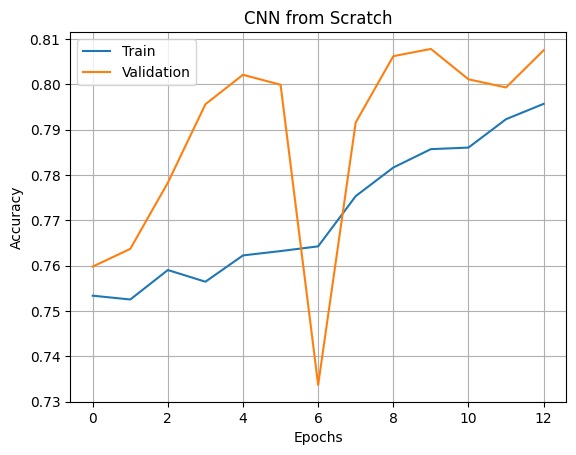

In [ ]:
# ------------------ Plotting ------------------
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

plot_history(history_scratch, "CNN from Scratch")


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load and preprocess CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Resize only on-the-fly (32x32 -> 96x96 to match MobileNetV2)
def preprocess(image, label):
    image = tf.image.resize(image, (96, 96))
    return image, label

batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.map(preprocess).shuffle(5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load MobileNetV2 base
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

# Add custom head
inputs = tf.keras.Input(shape=(96, 96, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Compile and train base
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, epochs=5, validation_data=test_ds)

# Unfreeze for fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, epochs=5, validation_data=test_ds)

# Final evaluation
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Final Test Accuracy (Transfer Learning - MobileNetV2): {test_acc * 100:.2f}%")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.6311 - loss: 1.0992 - val_accuracy: 0.7832 - val_loss: 0.6396
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7623 - loss: 0.6908 - val_accuracy: 0.7934 - val_loss: 0.5962
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.7824 - loss: 0.6327 - val_accuracy: 0.8008 - val_loss: 0.5749
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7914 - loss: 0.5970 - val_accuracy: 0.8036 - val_loss: 0.5615
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.7993 - loss: 0.5716 - val_accuracy: 0.8036 - val_loss: 0.5689
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 126s 96ms/step - accuracy: 0.6571 - loss: 1.4130 - val_accuracy: 0.8018 - val_loss: 0.6269
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - accuracy: 0.8241 - loss: 0.5729 - val_accuracy: 0.8375 - val_loss: 0.5026
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 55ms